<a href="https://colab.research.google.com/github/zhangou888/NN/blob/main/PyTorch_Neural_Network_on_Titanic_Dataset_(Binary_Classification)_with_SHAP_Explainability_and_Gradio_Interface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Neural Network on Titanic Dataset (Binary Classification) with SHAP Explainability and Gradio Interface

### A typical training procedure for a neural network is as follows:

1. Define the neural network that has some learnable parameters (or weights)

2. Iterate over a dataset of inputs

3. Process input through the network

4. Compute the loss (how far is the output from being correct)

5. Propagate gradients back into the network’s parameters

6. Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import shap  # SHAP explainability
import gradio as gr  # Web UI
import seaborn as sns
import numpy as np


In [3]:
# Step 1: Load Titanic dataset
# You can use seaborn or load from a CSV if using Kaggle
data = sns.load_dataset('titanic')

# Step 2: Drop columns with many missing values or not useful for modeling
cols_to_drop = ['deck', 'embark_town', 'alive', 'class', 'who']
data = data.drop(columns=cols_to_drop)

# Step 3: Drop remaining rows with missing values to simplify processing
data = data.dropna()
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,adult_male,alone
0,0,3,male,22.0,1,0,7.2500,S,True,False
1,1,1,female,38.0,1,0,71.2833,C,False,False
2,1,3,female,26.0,0,0,7.9250,S,False,True
3,1,1,female,35.0,1,0,53.1000,S,False,False
4,0,3,male,35.0,0,0,8.0500,S,True,True


In [4]:
# Step 4: Encode categorical columns ('sex' and 'embarked') into numeric
label_cols = ['sex', 'embarked']
for col in label_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

# Step 5: Select input features and label
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
X = data[features].values  # Input features
y = data['survived'].values  # Target: 0 = did not survive, 1 = survived

# Step 6: Normalize features for stable training
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
# Step 7: Split dataset into train/test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Convert NumPy arrays to PyTorch tensors for model training
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Wrap tensors in PyTorch DataLoader to manage batching during training
dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_test  = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader  = DataLoader(dataset_test, batch_size=32)

In [7]:
# Step 9: Define a simple feedforward neural network for binary classification
class TitanicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 16)  # Input: 7 features → 16 hidden neurons
        self.fc2 = nn.Linear(16, 8)  # Hidden layer → 8 neurons
        self.fc3 = nn.Linear(8, 1)   # Output layer → 1 neuron (binary output)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification output
        return x


In [8]:
# Step 10: Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TitanicNet().to(device)
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Step 11: Train the model for a fixed number of epochs
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

Epoch 1/30, Loss: 12.6993
Epoch 2/30, Loss: 12.5529
Epoch 3/30, Loss: 12.4201
Epoch 4/30, Loss: 12.2978
Epoch 5/30, Loss: 12.1735
Epoch 6/30, Loss: 12.0154
Epoch 7/30, Loss: 11.8276
Epoch 8/30, Loss: 11.5764
Epoch 9/30, Loss: 11.2050
Epoch 10/30, Loss: 10.7192
Epoch 11/30, Loss: 10.0186
Epoch 12/30, Loss: 9.3188
Epoch 13/30, Loss: 8.8229
Epoch 14/30, Loss: 8.4558
Epoch 15/30, Loss: 8.1848
Epoch 16/30, Loss: 8.0377
Epoch 17/30, Loss: 7.9740
Epoch 18/30, Loss: 7.9206
Epoch 19/30, Loss: 7.7399
Epoch 20/30, Loss: 7.7101
Epoch 21/30, Loss: 7.6591
Epoch 22/30, Loss: 7.5881
Epoch 23/30, Loss: 7.5538
Epoch 24/30, Loss: 7.5200
Epoch 25/30, Loss: 7.4702
Epoch 26/30, Loss: 7.4143
Epoch 27/30, Loss: 7.4278
Epoch 28/30, Loss: 7.3660
Epoch 29/30, Loss: 7.3507
Epoch 30/30, Loss: 7.3171


In [10]:
# Step 12: Evaluate model on test set
model.eval()
preds = []
labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds.extend(outputs.cpu().numpy())
        labels.extend(y_batch.numpy())

# Convert probabilities to binary predictions
preds_binary = [1 if p >= 0.5 else 0 for p in preds]
accuracy = accuracy_score(labels, preds_binary)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 79.72%


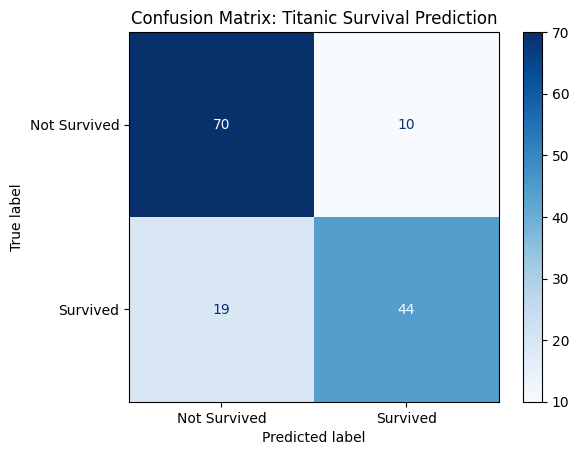

In [11]:
# Step 13: Visualize confusion matrix
cm = confusion_matrix(labels, preds_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Survived', 'Survived'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Titanic Survival Prediction")
plt.show()

In [14]:
# Step 14: SHAP Explainability
explainer = shap.DeepExplainer(model.cpu(), torch.tensor(X_train[:100], dtype=torch.float32))
shap_values = explainer.shap_values(torch.tensor(X_test[:10], dtype=torch.float32))
shap.summary_plot(shap_values[0], features=X_test[:10], feature_names=features)

AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 0.2806735038757324 - Tolerance: 0.01

In [15]:
# Step 15: Web Interface using Gradio
def predict_survival(pclass, sex, age, sibsp, parch, fare, embarked):
    # Convert inputs to the same scale and format used during training
    input_array = np.array([[pclass, sex, age, sibsp, parch, fare, embarked]])
    input_scaled = scaler.transform(input_array)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        prob = float(output.item())
        return {"Survived": round(prob, 3), "Did Not Survive": round(1 - prob, 3)}


In [16]:
# Step 15: Web Interface using Gradio
def predict_survival(pclass, sex, age, sibsp, parch, fare, embarked):
    # Convert inputs to the same scale and format used during training
    input_array = np.array([[pclass, sex, age, sibsp, parch, fare, embarked]])
    input_scaled = scaler.transform(input_array)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        prob = float(output.item())
        return {"Survived": round(prob, 3), "Did Not Survive": round(1 - prob, 3)}

# Define the Gradio interface with appropriate input types
iface = gr.Interface(
    fn=predict_survival,
    inputs=[
        gr.Slider(1, 3, step=1, label="Pclass (1 = 1st, 3 = 3rd)"),
        gr.Radio([0, 1], label="Sex (0 = Female, 1 = Male)"),
        gr.Number(label="Age"),
        gr.Number(label="Siblings/Spouses aboard"),
        gr.Number(label="Parents/Children aboard"),
        gr.Number(label="Fare"),
        gr.Radio([0, 1, 2], label="Embarked (0 = C, 1 = Q, 2 = S)")
    ],
    outputs="label",
    title="Titanic Survival Predictor"
)

# Launch the web interface
iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://346200fa3f6364b89b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
